<a href="https://colab.research.google.com/github/markste-in/collatz/blob/main/Dataset_NN_Colab_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with",device)

Working with cpu


In [4]:
import pandas as pd

In [8]:
import glob
files = glob.glob("gdrive/MyDrive/collatz_dbs/*.parquet")


In [11]:
 data = [pd.read_parquet(f) for f in files]
 df = pd.concat(data,ignore_index=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   Number              200000 non-null  int64
 1   Length              200000 non-null  int64
 2   Max                 200000 non-null  int64
 3   IsEven              200000 non-null  bool 
 4   nPrimes             200000 non-null  int64
 5   Smallest_Prime      200000 non-null  int64
 6   nSmallest_Prim      200000 non-null  int64
 7   Biggest_Prime       200000 non-null  int64
 8   nBiggest_Prime      200000 non-null  int64
 9   isPrime             200000 non-null  bool 
 10  preNumber           200000 non-null  int64
 11  preLength           200000 non-null  int64
 12  preMax              200000 non-null  int64
 13  preIsEven           200000 non-null  bool 
 14  prenPrimes          200000 non-null  int64
 15  preSmallest_Prime   200000 non-null  int64
 16  prenSmallest_Prim   

In [13]:
df.sample(5)

,Number,Length,Max,IsEven,nPrimes,Smallest_Prime,nSmallest_Prim,Biggest_Prime,nBiggest_Prime,isPrime,preNumber,preLength,preMax,preIsEven,prenPrimes,preSmallest_Prime,prenSmallest_Prim,preBiggest_Prime,prenBiggest_Prime,preisPrime,postNumber,postLength,postMax,postIsEven,postnPrimes,postSmallest_Prime,postnSmallest_Prim,postBiggest_Prime,postnBiggest_Prime,postisPrime
185186,213630119373,118,640890358120,False,5,3,1,433861,1,False,213630119372,118,240333884296,True,2,2,2,53407529843,1,False,213630119374,273,3897805169860,True,4,2,1,151609,1,False
27663,692896089771,192,3118032403972,False,3,3,2,228452387,1,False,692896089770,187,1039344134656,True,4,2,1,2598133,1,False,692896089772,192,1109885557876,True,4,2,2,6004507,1,False
133237,337569158862,341,6488646244072,True,5,2,1,1875947,1,False,337569158861,297,1012707476584,False,2,11,1,30688105351,1,False,337569158863,341,6488646244072,False,2,47,1,7182322529,1,False
31336,283092209050,289,424638313576,True,6,2,1,101117,1,False,283092209049,364,955436205544,False,4,3,1,6906541,1,False,283092209051,333,24820864630576,False,1,283092209051,1,283092209051,1,True
138840,739555766412,262,832000237216,True,4,2,2,2686207,1,False,739555766411,342,24983970710020,False,3,7,1,9604620343,1,False,739555766413,262,2218667299240,False,2,2141,1,345425393,1,False


In [14]:
x =df.loc[:, df.columns != 'Length'].values.astype('int64')
y = df["Length"].values
x = torch.tensor(x).float().to(device)
y = torch.tensor(y).float().to(device)

In [15]:
input_size = x.shape[1]
class NN(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(input_size,800)
        self.b1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.b22 = nn.BatchNorm1d(800)
        self.fc22 = nn.Linear(800,400)
        self.b2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.b1(x)
        x = F.relu(self.fc2(x))
        x = self.b22(x)
        x = F.relu(self.fc22(x ))
        x = self.b2(x)
        x = self.fc3(x)

        return x

def collatz_iter(n : int) -> int:
    iter = 0
    while (n>1):
        if n%2 == 0:
            n =n / 2
        else:
            n = n*3+1
        iter+=1
    return iter


In [16]:
PATH =  "gdrive/MyDrive/collatz_model2.pt"

In [17]:
batch_size = 32
model = NN().to(device)
opt = torch.optim.Adam(params=model.parameters(),lr = 0.1)
losses = list()


In [18]:
try:
  model.load_state_dict(torch.load(PATH,map_location=torch.device(device)))
  print("Previous model loaded")
except:
  print("No old model found. Train from scratch")

Previous model loaded


In [19]:
def batches(x,y, batch_size = 8):
  idx = np.random.randint(1,x.shape[0],batch_size)
  return x[idx,:],y[idx]

In [ ]:
for i in tqdm.tqdm(range(100000)):
    _x, _y = batches(x,y)
    opt.zero_grad()
    pred = model(_x)
    loss = ((_y-pred)**2).sum()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    opt.step()
    if i%100 ==0:
      torch.save(model.state_dict(), PATH)

 13%|█▎        | 12760/100000 [06:13<45:15, 32.13it/s]

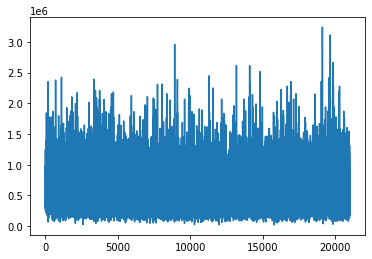

In [ ]:
plt.plot(losses)
#plt.yscale("log")
plt.show()

In [ ]:
_y,pred

(tensor([212., 426., 205., 261., 298., 365., 443., 256.]), tensor([[331.1168],
         [331.0028],
         [331.0925],
         [331.0018],
         [331.1981],
         [331.0192],
         [331.0569],
         [330.9954]], grad_fn=<AddmmBackward>))